# 0. Set-up

In [1]:
## Import packages
import gc
import os
import sys

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import lightgbm as lgb
import shap

In [2]:
user = os.getenv('USERNAME')
shared_workspace = '/home/nikankarla/modelling_club_team9'
user_dir = os.path.join(shared_workspace, user)
data_dir = os.path.join(shared_workspace, 'raw_data')
model_file_output_dir = os.path.join(user_dir, 'pipeline/input')

scoreboard_path = os.path.join(shared_workspace, "scoreboard/model_scores.json")

# 2. Import data

### application

In [3]:
## Read in data (only main data file)
home_loan_train = pd.read_csv(data_dir + '/raw/application_train.csv',index_col='SK_ID_CURR')
home_loan_test = pd.read_csv(data_dir + '/raw/application_test_noTarget.csv',index_col='SK_ID_CURR')
home_loan_test.loc[:, 'TARGET'] = None
train_response = home_loan_train['TARGET']
## select reduced set of features to work with
raw_features = [
    "AMT_GOODS_PRICE",
    "AMT_INCOME_TOTAL",
    "AMT_CREDIT",
    "AMT_ANNUITY",
    "NAME_CONTRACT_TYPE",
#     "EXT_SOURCE_1",
#     "EXT_SOURCE_2",
#     "EXT_SOURCE_3",
    "NAME_INCOME_TYPE",
    "CNT_FAM_MEMBERS",
    "OCCUPATION_TYPE",
    "DAYS_EMPLOYED",
    "DAYS_BIRTH",
    "NAME_EDUCATION_TYPE",
    
    "NAME_HOUSING_TYPE",
    "FLAG_OWN_REALTY",
    "REGION_POPULATION_RELATIVE",
    "REGION_RATING_CLIENT",
    "REG_CITY_NOT_LIVE_CITY",
    
    "YEARS_BUILD_AVG",
    "LANDAREA_AVG",
    "LIVINGAREA_AVG",
    "YEARS_BUILD_MEDI",
    "LANDAREA_MEDI",
    "LIVINGAREA_MEDI",
    "YEARS_BUILD_MODE",
    "LANDAREA_MODE",
    "LIVINGAREA_MODE",

#     "REGION_RATING_CLIENT_W_CITY",
#     "REG_REGION_NOT_LIVE_REGION",
#     "REG_REGION_NOT_WORK_REGION",
#     "LIVE_REGION_NOT_WORK_REGION",
#     "REG_CITY_NOT_WORK_CITY",
#     "REG_CITY_NOT_WORK_CITY",
#     "",
    
    "OBS_30_CNT_SOCIAL_CIRCLE",
    "DEF_30_CNT_SOCIAL_CIRCLE",
    "OBS_60_CNT_SOCIAL_CIRCLE",
    "DEF_60_CNT_SOCIAL_CIRCLE",
    
    
    "TARGET"
]
home_loan_train_limited_features = home_loan_train[raw_features]
home_loan_test_limited_features = home_loan_test[raw_features]

model_file = pd.concat(
    [
        home_loan_train_limited_features,
        home_loan_test_limited_features
    ],
    axis=0)
model_file['TARGET'] = model_file['TARGET'].astype(float)

## clean up variables
del [home_loan_train_limited_features, home_loan_test_limited_features]
gc.collect()

0

## Bureau data

Mortgage

In [4]:
Active_Mortgage_Clean = pd.read_csv(data_dir + '/engineered/bureau/Active_Mortgage_Clean.csv',index_col='SK_ID_CURR')
Active_Mortgage_Clean = Active_Mortgage_Clean.add_prefix('ACT_MORTG_')

In [5]:
Active_Mortgage_Clean_raw_features = ["ACT_MORTG_AMT_CREDIT_SUM_DEBT"]

In [6]:
model_file = model_file.merge(Active_Mortgage_Clean[Active_Mortgage_Clean_raw_features], on='SK_ID_CURR', how='left')

Consumer Credit

- Active

In [7]:
Active_ConsumerCredit_Agg = pd.read_csv(data_dir + '/engineered/bureau/Active_ConsumerCredit_Agg.csv',index_col=['SK_ID_CURR'])
Active_ConsumerCredit_Agg = Active_ConsumerCredit_Agg.add_prefix('ACT_CONCRED_')

In [8]:
Active_ConsumerCredit_Agg_Date = pd.read_csv(data_dir + '/engineered/bureau/Active_ConsumerCredit_Agg_Date.csv',index_col=['DATE_RANGE','SK_ID_CURR'])
Active_ConsumerCredit_Agg_Date = Active_ConsumerCredit_Agg_Date.add_prefix('ACT_CONCRED_')
Active_ConsumerCredit_Dates = Active_ConsumerCredit_Agg_Date.index.get_level_values("DATE_RANGE").unique()
#override
Active_ConsumerCredit_Dates = [1]

In [9]:
Active_ConsumerCredit_Agg_raw_features = [
                                          "ACT_CONCRED_AMT_CREDIT_MAX_OVERDUE",
#                                           "ACT_CONCRED_CNT_CREDIT_PROLONG",
                                          "ACT_CONCRED_AMT_CREDIT_SUM",
                                          "ACT_CONCRED_AMT_CREDIT_SUM_DEBT",
                                          "ACT_CONCRED_COUNT",
#                                           'ACT_CONCRED_CNT_CREDIT_PROLONG_MAX',
                                          'ACT_CONCRED_AMT_CREDIT_SUM_MAX', 
                                          'ACT_CONCRED_AMT_CREDIT_SUM_DEBT_MAX'
]

Active_ConsumerCredit_Agg_Date_raw_features = [
#                                           "ACT_CONCRED_AMT_CREDIT_MAX_OVERDUE",
#                                           "ACT_CONCRED_CNT_CREDIT_PROLONG",
                                          "ACT_CONCRED_AMT_CREDIT_SUM",
                                          "ACT_CONCRED_AMT_CREDIT_SUM_DEBT",
#                                           "ACT_CONCRED_COUNT",
#                                           'ACT_CONCRED_CNT_CREDIT_PROLONG_MAX',
                                          'ACT_CONCRED_AMT_CREDIT_SUM_MAX', 
                                          'ACT_CONCRED_AMT_CREDIT_SUM_DEBT_MAX'
]

In [10]:
 model_file = model_file.merge(Active_ConsumerCredit_Agg[Active_ConsumerCredit_Agg_raw_features], on='SK_ID_CURR', how='left')
    
for d in Active_ConsumerCredit_Dates:
    model_file = model_file.merge(Active_ConsumerCredit_Agg_Date.loc[d][Active_ConsumerCredit_Agg_Date_raw_features].add_prefix('D'+str(d)+'_'), on='SK_ID_CURR', how='left')

- Closed

In [11]:
Closed_ConsumerCredit_Agg = pd.read_csv(data_dir + '/engineered/bureau/Closed_ConsumerCredit_Agg.csv',index_col=['SK_ID_CURR'])
Closed_ConsumerCredit_Agg = Closed_ConsumerCredit_Agg.add_prefix('CLD_CONCRED_')

In [12]:
Closed_ConsumerCredit_Agg_raw_features = [
                                      "CLD_CONCRED_AMT_CREDIT_MAX_OVERDUE",
                                      "CLD_CONCRED_CNT_CREDIT_PROLONG",
                                      "CLD_CONCRED_AMT_CREDIT_SUM",
#                                       "CLD_CONCRED_AMT_CREDIT_SUM_DEBT"
                                      "CLD_CONCRED_COUNT",
                                      'CLD_CONCRED_CNT_CREDIT_PROLONG_MAX', 
                                      'CLD_CONCRED_AMT_CREDIT_SUM_MAX', 
#                                       'CLD_CONCRED_AMT_CREDIT_SUM_DEBT_MAX'
]

In [13]:
model_file = model_file.merge(Closed_ConsumerCredit_Agg[Closed_ConsumerCredit_Agg_raw_features], on='SK_ID_CURR', how='left')

Credit Card

- Active

In [14]:
Active_CreditCard_Agg = pd.read_csv(data_dir + '/engineered/bureau/Active_CreditCard_Agg.csv',index_col=['SK_ID_CURR'])
Active_CreditCard_Agg = Active_CreditCard_Agg.add_prefix('ACT_CREDCARD_')

In [15]:
Active_CreditCard_Agg_Date = pd.read_csv(data_dir + '/engineered/bureau/Active_CreditCard_Agg_Date.csv',index_col=['DATE_RANGE','SK_ID_CURR'])
Active_CreditCard_Agg_Date = Active_CreditCard_Agg_Date.add_prefix('ACT_CREDCARD_')
Active_CreditCard_Dates = Active_CreditCard_Agg_Date.index.get_level_values("DATE_RANGE").unique()
#override
Active_CreditCard_Dates = [1]

In [16]:
Active_CreditCard_Agg_raw_features = [
                                      "ACT_CREDCARD_AMT_CREDIT_MAX_OVERDUE",
#                                       "ACT_CREDCARD_CNT_CREDIT_PROLONG",
                                      "ACT_CREDCARD_AMT_CREDIT_SUM",
                                      "ACT_CREDCARD_AMT_CREDIT_SUM_DEBT",
                                      "ACT_CREDCARD_AMT_CREDIT_SUM_LIMIT",
                                      "ACT_CREDCARD_COUNT",
#                                       'ACT_CREDCARD_CNT_CREDIT_PROLONG_MAX', 
                                      'ACT_CREDCARD_AMT_CREDIT_SUM_MAX', 
                                      'ACT_CREDCARD_AMT_CREDIT_SUM_DEBT_MAX', 
                                      'ACT_CREDCARD_AMT_CREDIT_SUM_LIMIT_MAX'
]

Active_CreditCard_Agg_Date_raw_features = [
#                                       "ACT_CREDCARD_AMT_CREDIT_MAX_OVERDUE",
#                                       "ACT_CREDCARD_CNT_CREDIT_PROLONG",
                                      "ACT_CREDCARD_AMT_CREDIT_SUM",
                                      "ACT_CREDCARD_AMT_CREDIT_SUM_DEBT",
#                                       "ACT_CREDCARD_AMT_CREDIT_SUM_LIMIT",
#                                       "ACT_CREDCARD_COUNT",
#                                       'ACT_CREDCARD_CNT_CREDIT_PROLONG_MAX', 
                                      'ACT_CREDCARD_AMT_CREDIT_SUM_MAX', 
                                      'ACT_CREDCARD_AMT_CREDIT_SUM_DEBT_MAX', 
#                                       'ACT_CREDCARD_AMT_CREDIT_SUM_LIMIT_MAX'
]

In [17]:
model_file = model_file.merge(Active_CreditCard_Agg[Active_CreditCard_Agg_raw_features], on='SK_ID_CURR', how='left')

for d in Active_CreditCard_Dates:
    model_file = model_file.merge(Active_CreditCard_Agg_Date.loc[d][Active_CreditCard_Agg_Date_raw_features].add_prefix('D'+str(d)+'_'), on='SK_ID_CURR', how='left')

- Closed

In [18]:
Closed_CreditCard_Agg = pd.read_csv(data_dir + '/engineered/bureau/Closed_CreditCard_Agg.csv',index_col=['SK_ID_CURR'])
Closed_CreditCard_Agg = Closed_CreditCard_Agg.add_prefix('CLD_CREDCARD_')

In [19]:
Closed_CreditCard_Agg_raw_features = [
                                      "CLD_CREDCARD_AMT_CREDIT_MAX_OVERDUE",
                                      "CLD_CREDCARD_CNT_CREDIT_PROLONG",
                                      "CLD_CREDCARD_AMT_CREDIT_SUM",
#                                       "CLD_CREDCARD_AMT_CREDIT_SUM_DEBT",
                                      "CLD_CREDCARD_AMT_CREDIT_SUM_LIMIT",
                                      "CLD_CREDCARD_COUNT",
                                      'CLD_CREDCARD_CNT_CREDIT_PROLONG_MAX', 
                                      'CLD_CREDCARD_AMT_CREDIT_SUM_MAX', 
#                                       'CLD_CREDCARD_AMT_CREDIT_SUM_DEBT_MAX', 
                                      'CLD_CREDCARD_AMT_CREDIT_SUM_LIMIT_MAX'
]

Other

- Active

In [72]:
model_file = model_file.merge(Closed_CreditCard_Agg[Closed_CreditCard_Agg_raw_features], on='SK_ID_CURR', how='left')

Raw model file

In [73]:
model_file

,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,NAME_CONTRACT_TYPE,NAME_INCOME_TYPE,CNT_FAM_MEMBERS,OCCUPATION_TYPE,DAYS_EMPLOYED,DAYS_BIRTH,...,D1_ACT_CREDCARD_AMT_CREDIT_SUM_MAX,D1_ACT_CREDCARD_AMT_CREDIT_SUM_DEBT_MAX,CLD_CREDCARD_AMT_CREDIT_MAX_OVERDUE,CLD_CREDCARD_CNT_CREDIT_PROLONG,CLD_CREDCARD_AMT_CREDIT_SUM,CLD_CREDCARD_AMT_CREDIT_SUM_LIMIT,CLD_CREDCARD_COUNT,CLD_CREDCARD_CNT_CREDIT_PROLONG_MAX,CLD_CREDCARD_AMT_CREDIT_SUM_MAX,CLD_CREDCARD_AMT_CREDIT_SUM_LIMIT_MAX
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
113072,180000.0,283500.0,180000.0,9000.0,Revolving loans,Commercial associate,2.0,Laborers,-9894,-20259,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
225465,144000.0,67500.0,182016.0,10291.5,Cash loans,Pensioner,2.0,NaN,365243,-24241,...,NaN,NaN,NaN,0.0,66289.5,0.0,1.0,0.0,66289.5,NaN
260656,315000.0,112500.0,315000.0,17716.5,Cash loans,State servant,2.0,Medicine staff,-12081,-19449,...,NaN,NaN,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
445761,1800000.0,675000.0,2156400.0,59301.0,Cash loans,Commercial associate,2.0,Medicine staff,-1195,-16253,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
421144,679500.0,180000.0,679500.0,19867.5,Cash loans,Commercial associate,2.0,NaN,-188,-10579,...,135000.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456245,225000.0,81000.0,269550.0,11871.0,Cash loans,Commercial associate,5.0,Low-skill Laborers,-1046,-12961,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
456247,247500.0,112500.0,345510.0,17770.5,Cash loans,Commercial associate,1.0,Core staff,-399,-11870,...,94500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
456248,225000.0,153000.0,331920.0,16096.5,Cash loans,Working,1.0,Sales staff,-7258,-16705,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 3. Feature engineering

### Macro

In [74]:
model_file["LOAN_LENGTH"] = model_file["AMT_CREDIT"]/model_file["AMT_ANNUITY"]
model_file["LOAN_STRESS"] = model_file["AMT_ANNUITY"]/model_file["AMT_INCOME_TOTAL"]
model_file["PRICE_CREDIT_RATIO"] = model_file["AMT_GOODS_PRICE"]/model_file["AMT_CREDIT"]

In [75]:
model_file["AMT_ANNUITY"].loc[model_file["AMT_ANNUITY"]>100000] = 100000
model_file["AMT_CREDIT"].loc[model_file["AMT_CREDIT"]>2000000] = 2000000
model_file["AMT_GOODS_PRICE"].loc[model_file["AMT_GOODS_PRICE"]>2000000] = 2000000
model_file["AMT_INCOME_TOTAL"].loc[model_file["AMT_INCOME_TOTAL"]>1000000] = 1000000
model_file["LOAN_LENGTH"].loc[model_file["LOAN_LENGTH"]>40] = 40
model_file["LOAN_STRESS"].loc[model_file["LOAN_STRESS"]>0.75] = 0.75
model_file["PRICE_CREDIT_RATIO"].loc[model_file["PRICE_CREDIT_RATIO"]>1.25] = 1.25
model_file["PRICE_CREDIT_RATIO"].loc[model_file["PRICE_CREDIT_RATIO"]<0.5] = 0.5


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Demographic

In [76]:
model_file["OCCUPATION_TYPE"].loc[model_file["OCCUPATION_TYPE"]=="Low-skill Laborers"] = "Laborers"
model_file["OCCUPATION_TYPE"].loc[model_file["OCCUPATION_TYPE"]=="Waiters/barmen staff"] = "Laborers"
model_file["OCCUPATION_TYPE"].loc[model_file["OCCUPATION_TYPE"]=="IT staff"] = "High skill tech staff"
model_file["OCCUPATION_TYPE"].loc[model_file["OCCUPATION_TYPE"]=="HR staff"] = "Secretaries"

In [77]:
# fig, ax = plt.subplots()
# ax.hist(model_file["OCCUPATION_TYPE"].dropna())
# ax.tick_params(labelrotation=45)
# fig.set_size_inches(24, 5)

In [78]:
model_file["DAYS_EMPLOYED"].loc[model_file["DAYS_EMPLOYED"]==365243.000000] = None
model_file['DAYS_EMPLOYED_PERCENT'] = model_file['DAYS_EMPLOYED'] / model_file['DAYS_BIRTH']
model_file["YEARS_EMPLOYED"] = model_file["DAYS_EMPLOYED"]/365
model_file["YEARS_BIRTH"] = model_file["DAYS_BIRTH"]/365
model_file["HIGHER_ED"] = model_file["NAME_EDUCATION_TYPE"].isin(['Higher education', 'Academic degree'])

In [79]:
model_file["NAME_INCOME_TYPE"].loc[model_file["NAME_INCOME_TYPE"]=="Student"] = "Unemployed"
model_file["NAME_INCOME_TYPE"].loc[model_file["NAME_INCOME_TYPE"]=="Maternity leave"] = "Unemployed"
model_file["NAME_INCOME_TYPE"].loc[model_file["NAME_INCOME_TYPE"]=="Pensioner"] ="Unemployed"
model_file["NAME_INCOME_TYPE"].loc[model_file["NAME_INCOME_TYPE"]=="Businessman"] = "Working"

### Regional

In [80]:
    "NAME_HOUSING_TYPE",
    "FLAG_OWN_REALTY",
    "REGION_POPULATION_RELATIVE",
    "REGION_RATING_CLIENT",

('REGION_RATING_CLIENT',)

In [81]:
plt.rcParams['figure.figsize'] = (20, 7)

(array([ 32197.,      0.,      0.,      0.,      0., 226984.,      0.,
             0.,      0.,  48330.]),
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ]),
 <a list of 10 Patch objects>)

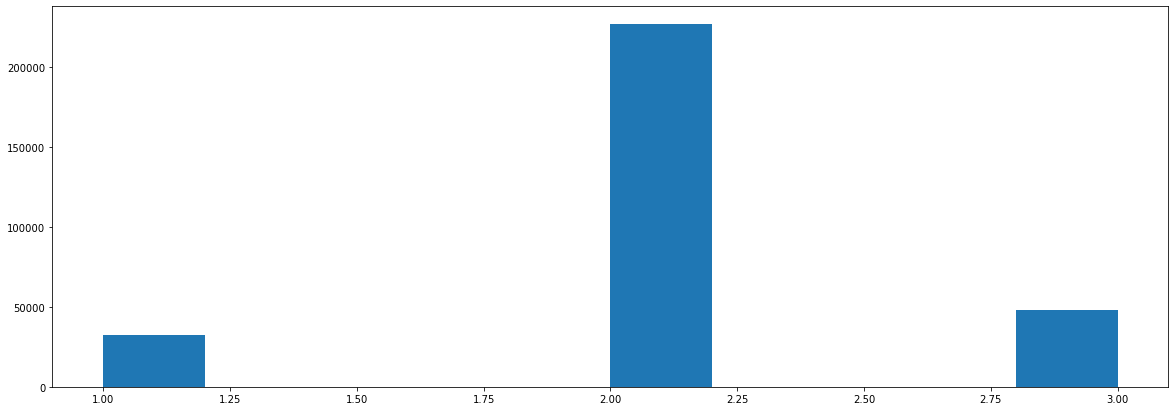

In [82]:
plt.hist(model_file["REGION_RATING_CLIENT"])

### External

In [83]:
# fig, ax = plt.subplots(1,2)
# ax[0].hist(model_file[model_file["TARGET"]==0]["FLAG_OWN_CAR"])
# ax[1].hist(model_file[model_file["TARGET"]==1]["FLAG_OWN_CAR"])

### Active_Mortgage

In [84]:
model_file["ACT_MORTG_AMT_CREDIT_SUM_DEBT"] = model_file["ACT_MORTG_AMT_CREDIT_SUM_DEBT"].fillna(0)


### Active Consumer Credit

In [85]:
model_file["ACT_CONCRED_AMT_CREDIT_MAX_OVERDUE"] = model_file["ACT_CONCRED_AMT_CREDIT_MAX_OVERDUE"].fillna(0)
# model_file["ACT_CONCRED_CNT_CREDIT_PROLONG"] = model_file["ACT_CONCRED_CNT_CREDIT_PROLONG"].fillna(0)
model_file["ACT_CONCRED_COUNT"] = model_file["ACT_CONCRED_COUNT"].fillna(0)  

In [86]:
model_file["ACT_CONCRED_AMT_CREDIT_MAX_OVERDUE"].loc[model_file["ACT_CONCRED_AMT_CREDIT_MAX_OVERDUE"]>100000] = 100000
model_file["ACT_CONCRED_COUNT"].loc[model_file["ACT_CONCRED_COUNT"]>2] = 2

In [87]:
for d in Active_ConsumerCredit_Dates:
#     model_file['D'+str(d)+ "_ACT_CONCRED_AMT_CREDIT_MAX_OVERDUE"] = model_file['D'+str(d)+ "_ACT_CONCRED_AMT_CREDIT_MAX_OVERDUE"].fillna(0)
#     model_file['D'+str(d)+ "_ACT_CONCRED_CNT_CREDIT_PROLONG"] = model_file['D'+str(d)+ "_ACT_CONCRED_CNT_CREDIT_PROLONG"].fillna(0)
    model_file['D'+str(d)+ "_ACT_CONCRED_AMT_CREDIT_SUM"] = model_file['D'+str(d)+ "_ACT_CONCRED_AMT_CREDIT_SUM"].fillna(0)
    model_file['D'+str(d)+ "_ACT_CONCRED_AMT_CREDIT_SUM_DEBT"] = model_file['D'+str(d)+ "_ACT_CONCRED_AMT_CREDIT_SUM_DEBT"].fillna(0)
#     model_file['D'+str(d)+ "_ACT_CONCRED_COUNT"] = model_file['D'+str(d)+ "_ACT_CONCRED_COUNT"].fillna(0)   
    model_file['D'+str(d)+ "_ACT_CONCRED_AMT_CREDIT_SUM_MAX"] = model_file['D'+str(d)+ "_ACT_CONCRED_AMT_CREDIT_SUM_MAX"].fillna(0)
    model_file['D'+str(d)+ "_ACT_CONCRED_AMT_CREDIT_SUM_DEBT_MAX"] = model_file['D'+str(d)+ "_ACT_CONCRED_AMT_CREDIT_SUM_DEBT_MAX"].fillna(0)


In [88]:
for d in Active_ConsumerCredit_Dates:
#     model_file['D'+str(d)+ "_ACT_CONCRED_AMT_CREDIT_MAX_OVERDUE"].loc[model_file['D'+str(d)+ "_ACT_CONCRED_AMT_CREDIT_MAX_OVERDUE"]>100000] = 100000
    model_file['D'+str(d)+ "_ACT_CONCRED_AMT_CREDIT_SUM"].loc[model_file['D'+str(d)+ "_ACT_CONCRED_AMT_CREDIT_SUM"]>1000000] = 1000000
    model_file['D'+str(d)+ "_ACT_CONCRED_AMT_CREDIT_SUM_DEBT"].loc[model_file['D'+str(d)+ "_ACT_CONCRED_AMT_CREDIT_SUM_DEBT"]>1000000] = 1000000
#     model_file['D'+str(d)+ "_ACT_CONCRED_COUNT"].loc[model_file['D'+str(d)+ "_ACT_CONCRED_COUNT"]>2] = 2

### Active Credit Card

In [89]:
model_file["ACT_CREDCARD_AMT_CREDIT_MAX_OVERDUE"] = model_file["ACT_CREDCARD_AMT_CREDIT_MAX_OVERDUE"].fillna(0)
# model_file["ACT_CREDCARD_CNT_CREDIT_PROLONG"] = model_file["ACT_CREDCARD_CNT_CREDIT_PROLONG"].fillna(0)
model_file["ACT_CREDCARD_COUNT"] = model_file["ACT_CREDCARD_COUNT"].fillna(0)
model_file["ACT_CREDCARD_AMT_CREDIT_SUM_LIMIT_MAX"] = model_file["ACT_CREDCARD_AMT_CREDIT_SUM_LIMIT_MAX"].fillna(0)

In [90]:
model_file["ACT_CREDCARD_AMT_CREDIT_MAX_OVERDUE"].loc[model_file["ACT_CREDCARD_AMT_CREDIT_MAX_OVERDUE"]>50000] = 50000
# model_file["ACT_CREDCARD_CNT_CREDIT_PROLONG"].loc[model_file["ACT_CREDCARD_CNT_CREDIT_PROLONG"]>2] = 2
model_file["ACT_CREDCARD_COUNT"].loc[model_file["ACT_CREDCARD_COUNT"]>20] = 20

In [91]:
for d in Active_CreditCard_Dates:
#     model_file['D'+str(d)+ "_ACT_CREDCARD_AMT_CREDIT_MAX_OVERDUE"] = model_file['D'+str(d)+ "_ACT_CREDCARD_AMT_CREDIT_MAX_OVERDUE"].fillna(0)
    # model_file['D'+str(d)+ "_ACT_CREDCARD_CNT_CREDIT_PROLONG"] = model_file['D'+str(d)+ "_ACT_CREDCARD_CNT_CREDIT_PROLONG"].fillna(0)
    model_file['D'+str(d)+ "_ACT_CREDCARD_AMT_CREDIT_SUM"] = model_file['D'+str(d)+ "_ACT_CREDCARD_AMT_CREDIT_SUM"].fillna(0)
    model_file['D'+str(d)+ "_ACT_CREDCARD_AMT_CREDIT_SUM_DEBT"] = model_file['D'+str(d)+ "_ACT_CREDCARD_AMT_CREDIT_SUM_DEBT"].fillna(0)
#     model_file['D'+str(d)+ "_ACT_CREDCARD_COUNT"] = model_file['D'+str(d)+ "_ACT_CREDCARD_COUNT"].fillna(0)
    model_file['D'+str(d)+ "_ACT_CREDCARD_AMT_CREDIT_SUM_MAX"] = model_file['D'+str(d)+ "_ACT_CREDCARD_AMT_CREDIT_SUM_MAX"].fillna(0)
    model_file['D'+str(d)+ "_ACT_CREDCARD_AMT_CREDIT_SUM_DEBT_MAX"] = model_file['D'+str(d)+ "_ACT_CREDCARD_AMT_CREDIT_SUM_DEBT_MAX"].fillna(0)
#     model_file['D'+str(d)+ "_ACT_CREDCARD_AMT_CREDIT_SUM_LIMIT_MAX"] = model_file['D'+str(d)+ "_ACT_CREDCARD_AMT_CREDIT_SUM_LIMIT_MAX"].fillna(0)

In [92]:
for d in Active_CreditCard_Dates:
#     model_file['D'+str(d)+ "_ACT_CREDCARD_AMT_CREDIT_MAX_OVERDUE"].loc[model_file['D'+str(d)+ "_ACT_CREDCARD_AMT_CREDIT_MAX_OVERDUE"]>50000] = 50000
    # model_file['D'+str(d)+ "_ACT_CREDCARD_CNT_CREDIT_PROLONG"].loc[model_file['D'+str(d)+ "_ACT_CREDCARD_CNT_CREDIT_PROLONG"]>2] = 2
    model_file['D'+str(d)+ "_ACT_CREDCARD_AMT_CREDIT_SUM"].loc[model_file['D'+str(d)+ "_ACT_CREDCARD_AMT_CREDIT_SUM"]>1000000] = 1000000
    model_file['D'+str(d)+ "_ACT_CREDCARD_AMT_CREDIT_SUM_DEBT"].loc[model_file['D'+str(d)+ "_ACT_CREDCARD_AMT_CREDIT_SUM_DEBT"]>1000000] = 1000000
#     model_file['D'+str(d)+ "_ACT_CREDCARD_COUNT"].loc[model_file['D'+str(d)+ "_ACT_CREDCARD_COUNT"]>20] = 20

### Closed Credit Card & Cons Cred

In [93]:
for x in model_file.columns: 
    if "CLD" in x:
        model_file[x] = model_file[x].fillna(0)

### Final model file

In [94]:
model_file = model_file.drop(["DAYS_EMPLOYED","DAYS_BIRTH","NAME_INCOME_TYPE"],axis=1)

In [95]:
model_file

,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,NAME_CONTRACT_TYPE,CNT_FAM_MEMBERS,OCCUPATION_TYPE,NAME_EDUCATION_TYPE,NAME_HOUSING_TYPE,FLAG_OWN_REALTY,...,CLD_CREDCARD_CNT_CREDIT_PROLONG_MAX,CLD_CREDCARD_AMT_CREDIT_SUM_MAX,CLD_CREDCARD_AMT_CREDIT_SUM_LIMIT_MAX,LOAN_LENGTH,LOAN_STRESS,PRICE_CREDIT_RATIO,DAYS_EMPLOYED_PERCENT,YEARS_EMPLOYED,YEARS_BIRTH,HIGHER_ED
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
113072,180000.0,283500.0,180000.0,9000.0,Revolving loans,2.0,Laborers,Secondary / secondary special,House / apartment,Y,...,0.0,0.0,0.0,20.000000,0.031746,1.000000,0.488376,-27.106849,-55.504110,False
225465,144000.0,67500.0,182016.0,10291.5,Cash loans,2.0,NaN,Secondary / secondary special,House / apartment,Y,...,0.0,66289.5,0.0,17.686052,0.152467,0.791139,NaN,NaN,-66.413699,False
260656,315000.0,112500.0,315000.0,17716.5,Cash loans,2.0,Medicine staff,Secondary / secondary special,House / apartment,Y,...,0.0,0.0,0.0,17.780036,0.157480,1.000000,0.621163,-33.098630,-53.284932,False
445761,1800000.0,675000.0,2000000.0,59301.0,Cash loans,2.0,Medicine staff,Secondary / secondary special,House / apartment,Y,...,0.0,0.0,0.0,36.363636,0.087853,0.834725,0.073525,-3.273973,-44.528767,False
421144,679500.0,180000.0,679500.0,19867.5,Cash loans,2.0,NaN,Secondary / secondary special,House / apartment,Y,...,0.0,0.0,0.0,34.201586,0.110375,1.000000,0.017771,-0.515068,-28.983562,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456245,225000.0,81000.0,269550.0,11871.0,Cash loans,5.0,Laborers,Secondary / secondary special,House / apartment,Y,...,0.0,0.0,0.0,22.706596,0.146556,0.834725,0.080704,-2.865753,-35.509589,False
456247,247500.0,112500.0,345510.0,17770.5,Cash loans,1.0,Core staff,Higher education,House / apartment,Y,...,0.0,0.0,0.0,19.442897,0.157960,0.716332,0.033614,-1.093151,-32.520548,True
456248,225000.0,153000.0,331920.0,16096.5,Cash loans,1.0,Sales staff,Secondary / secondary special,House / apartment,Y,...,0.0,0.0,0.0,20.620632,0.105206,0.677874,0.434481,-19.884932,-45.767123,False


In [96]:
model_file.to_csv(os.path.join(model_file_output_dir,'model_file.csv'))


# Archive

### bureau

In [58]:
bureau_manual = pd.read_csv(data_dir + '/engineered/bureau/manual.csv',index_col='SK_ID_CURR')
bureau_manual = bureau_manual.add_prefix('BUREAU_MANUAL_')

In [59]:
bureau_manual_raw_features = [
    "BUREAU_MANUAL_DAYS_CREDITmean",
    "BUREAU_MANUAL_AMT_CREDIT_SUM_DEBTsum",
    "BUREAU_MANUAL_AMT_CREDIT_MAX_OVERDUEmax",
    "BUREAU_MANUAL_AMT_CREDIT_SUMsum",
    "BUREAU_MANUAL_CREDIT_DAY_OVERDUEmax",
    "BUREAU_MANUAL_CNT_CREDIT_PROLONGsum",
]

In [60]:
bureau_manual = bureau_manual[bureau_manual_raw_features]

In [61]:
bureau_manual["BUREAU_MANUAL_DEBT_CREDIT_RATIO"] = bureau_manual["BUREAU_MANUAL_AMT_CREDIT_SUM_DEBTsum"]/bureau_manual["BUREAU_MANUAL_AMT_CREDIT_SUMsum"]
bureau_manual["BUREAU_MANUAL_DEBT_CREDIT_RATIO"].loc[bureau_manual["BUREAU_MANUAL_DEBT_CREDIT_RATIO"]<0] = 0
bureau_manual["BUREAU_MANUAL_DEBT_CREDIT_RATIO"].loc[bureau_manual["BUREAU_MANUAL_DEBT_CREDIT_RATIO"]>1] = 1

bureau_manual["BUREAU_MANUAL_AMT_CREDIT_SUM_DEBTsum"].loc[bureau_manual["BUREAU_MANUAL_AMT_CREDIT_SUM_DEBTsum"]>10000000] = 10000000
bureau_manual["BUREAU_MANUAL_AMT_CREDIT_SUM_DEBTsum"].loc[bureau_manual["BUREAU_MANUAL_AMT_CREDIT_SUM_DEBTsum"]<-250000] = -250000
bureau_manual["BUREAU_MANUAL_AMT_CREDIT_SUMsum"].loc[bureau_manual["BUREAU_MANUAL_AMT_CREDIT_SUMsum"]>10000000] = 10000000

bureau_manual["BUREAU_MANUAL_AMT_CREDIT_MAX_OVERDUEmax"].loc[bureau_manual["BUREAU_MANUAL_AMT_CREDIT_MAX_OVERDUEmax"]>250000] = 250000

bureau_manual["BUREAU_MANUAL_CREDIT_OVERDUE"] = bureau_manual["BUREAU_MANUAL_CREDIT_DAY_OVERDUEmax"]>0
bureau_manual["BUREAU_MANUAL_CREDIT_PROLONGED"] = bureau_manual["BUREAU_MANUAL_CNT_CREDIT_PROLONGsum"]>0


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


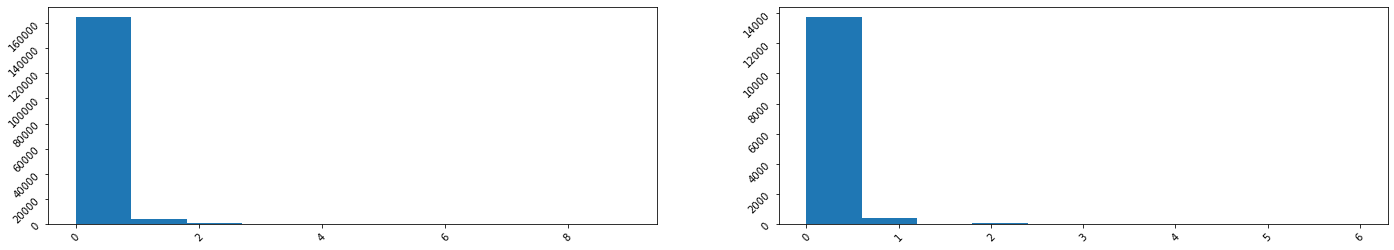

In [62]:
plot_file = bureau_manual.merge(train_response, on='SK_ID_CURR', how='inner')

fig, ax = plt.subplots(1,2)
ax[0].hist(plot_file[plot_file["TARGET"]==0]["BUREAU_MANUAL_CNT_CREDIT_PROLONGsum"].dropna())
ax[0].tick_params(labelrotation=45)
ax[1].hist(plot_file[plot_file["TARGET"]==1]["BUREAU_MANUAL_CNT_CREDIT_PROLONGsum"].dropna())
ax[1].tick_params(labelrotation=45)
fig.set_size_inches(24, 4)

In [ ]:
model_file = model_file.merge(bureau_manual, on='SK_ID_CURR', how='left')
model_file